<a href="https://colab.research.google.com/github/seongwoojang1123/TMJ-osteoarthritis-diagnosis-/blob/main/6_Case_Delong's_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Delong's Test P-Value Table:
                                     CBCT1,3   CBCT2,4  \
CBCT1,3                             0.000000  0.582553   
CBCT2,4                             0.582553  0.000000   
CBCT1,2,3,4(combining)              0.825986  0.741625   
CBCT1,3 + CBCT2,4 Fine Tuning       0.971066  0.780122   
CBCT1,3 + CBCT2,4 ensemble          0.126055  0.224847   
CBCT2,4 + CBCT1,3 Fine Tuning       0.971809  0.725748   
CBCT2,4 + CBCT1,3 ensemble          0.152000  0.264227   
MRI1,2                              0.660427  0.912871   
MRI3,4                              0.652072  0.922042   
MRI1,2,3,4(combining)               0.030935  0.108194   
CBCT1,3 + MRI1,2 Fine Tuning        0.803155  0.424152   
CBCT1,3 + MRI1,2 ensemble           0.895953  0.853506   
CBCT2,4 + MRI3,4 Fine Tuning        0.581702  0.813908   
CBCT2,4 + MRI3,4 ensemble           0.324983  0.503805   
MRI1,2 + CBCT1,3 Fine Tuning        0.713933  0.495110   
MRI1,2 + CBCT1,3 ensemble           0.02338

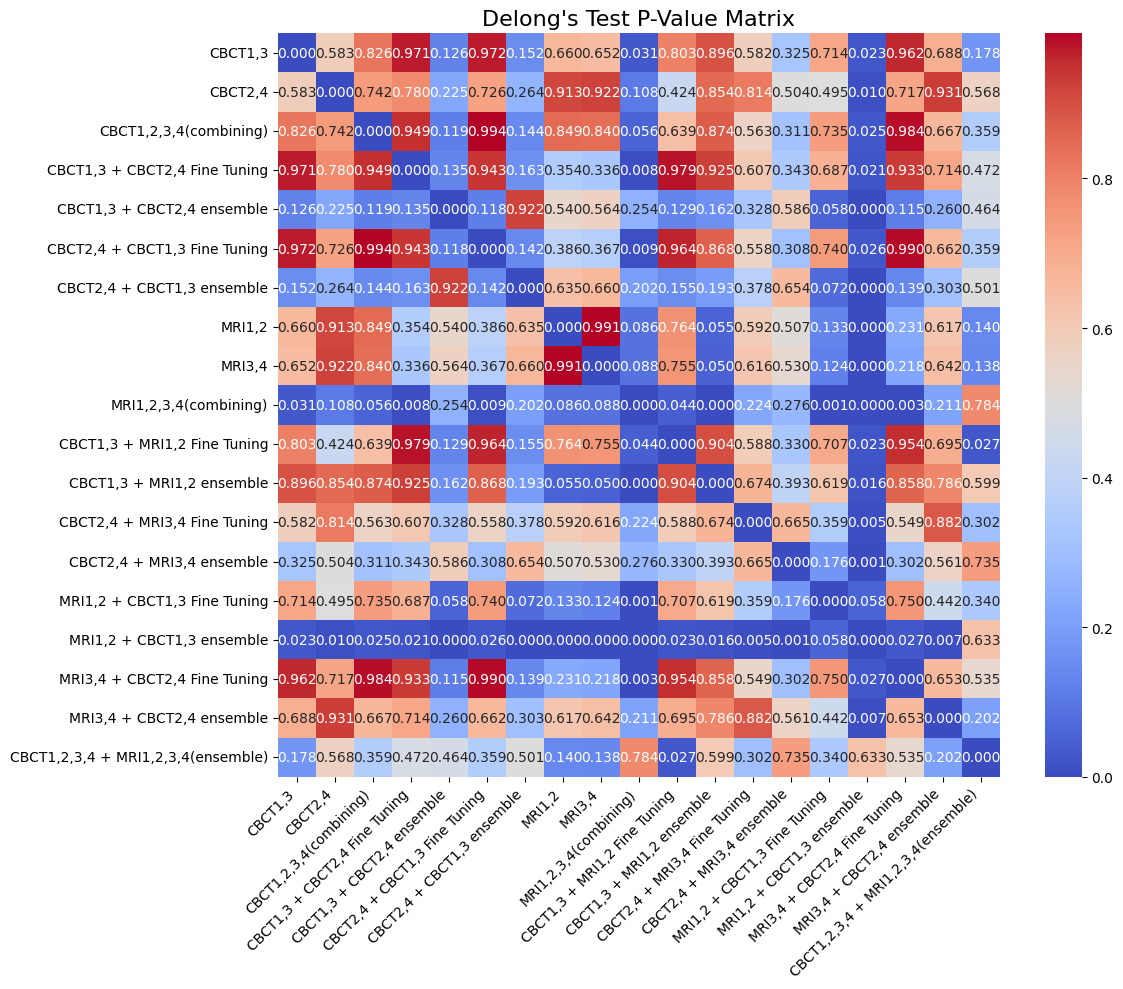

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# AUROC 데이터 입력
auroc_data = {
    "CBCT1,3": [0.6763, 0.7271, 0.7847],
    "CBCT2,4": [0.7399, 0.7611, 0.7885],
    "CBCT1,2,3,4(combining)": [0.7208, 0.7373, 0.7711],
    "CBCT1,3 + CBCT2,4 Fine Tuning": [None, 0.7441, 0.7721],
    "CBCT1,3 + CBCT2,4 ensemble": [None, 0.8279, 0.8563],
    "CBCT2,4 + CBCT1,3 Fine Tuning": [None, 0.7318, 0.7757],
    "CBCT2,4 + CBCT1,3 ensemble": [None, 0.8247, 0.8494],
    "MRI1,2": [0.6906, None, 0.8246],
    "MRI3,4": [0.6901, None, 0.8265],
    "MRI1,2,3,4(combining)": [0.7979, None, 0.9081],
    "CBCT1,3 + MRI1,2 Fine Tuning": [0.6277, 0.6623, 0.8507],
    "CBCT1,3 + MRI1,2 ensemble": [None, 0.8167, 0.7109],
    "CBCT2,4 + MRI3,4 Fine Tuning": [None, 0.7246, 0.8525],
    "CBCT2,4 + MRI3,4 ensemble": [None, 0.7672, 0.8588],
    "MRI1,2 + CBCT1,3 Fine Tuning": [None, 0.7295, 0.7371],
    "MRI1,2 + CBCT1,3 ensemble": [None, 0.8141, 0.4029],
    "MRI3,4 + CBCT2,4 Fine Tuning": [None, 0.7501, 0.7559],
    "MRI3,4 + CBCT2,4 ensemble": [None, 0.7091, 0.8507],
    "CBCT1,2,3,4 + MRI1,2,3,4(ensemble)": [0.7821, 0.7871, None],
}

# AUROC 데이터를 DataFrame으로 변환
auroc_df = pd.DataFrame(auroc_data, index=["1st", "2nd Crop", "3rd NEW Image"]).T

# Delong's Test 계산 함수
def delongs_test(auroc1, auroc2, n=100):
    """
    Delong's Test를 통해 두 AUROC 값의 p-value 계산
    """
    diff = auroc1 - auroc2
    std_error = np.sqrt((auroc1 * (1 - auroc1) + auroc2 * (1 - auroc2)) / n)
    z_score = diff / std_error
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return p_value

# p-value 매트릭스 생성
cases = auroc_df.index.tolist()
n_cases = len(cases)
auroc_values = auroc_df.values
p_value_matrix = np.zeros((n_cases, n_cases))

for i, j in combinations(range(n_cases), 2):
    valid_indices = ~np.isnan(auroc_values[[i, j], :]).any(axis=0)
    if valid_indices.any():
        p_value_matrix[i, j] = delongs_test(
            np.mean(auroc_values[i, valid_indices]),
            np.mean(auroc_values[j, valid_indices]),
        )
        p_value_matrix[j, i] = p_value_matrix[i, j]

p_value_df = pd.DataFrame(p_value_matrix, index=cases, columns=cases)

# p-value 테이블 출력
print("Delong's Test P-Value Table:")
print(p_value_df)

# p-value 테이블 저장
p_value_df.to_csv("Delongs_Test_P_Value_Matrix.csv")

# p-value 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(p_value_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=True,
            xticklabels=p_value_df.columns, yticklabels=p_value_df.index)
plt.title("Delong's Test P-Value Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# 히트맵 저장
plt.savefig("Delongs_Test_P_Value_Heatmap.png")
plt.show()